In [1]:
import GEMVAE

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import warnings
warnings.filterwarnings("ignore")

In [3]:
dir = r'data\SPATIAL CITE SEQ\GSM6578074_humanskin_protein.tsv'
pdata = sc.read_csv(dir, delimiter='\t')
pdata

AnnData object with n_obs × n_vars = 1691 × 283

In [4]:
dir = r'data\SPATIAL CITE SEQ\GSM6578065_humanskin_RNA.tsv'
gdata = sc.read_csv(dir, delimiter='\t')
gdata

AnnData object with n_obs × n_vars = 1691 × 15486

In [5]:
df = pd.read_csv(dir,sep='\t')

In [6]:
df['X']

0       15x34
1       34x34
2       19x30
3       31x35
4        6x22
        ...  
1686    12x26
1687    43x27
1688     48x6
1689    42x17
1690    45x44
Name: X, Length: 1691, dtype: object

In [7]:
# Extract the numerical values and convert them to a NumPy array
df['X'] = df['X'].str.split('x').apply(lambda x: [int(val) for val in x])
result_array = np.array(df['X'].tolist())

print(result_array)


[[15 34]
 [34 34]
 [19 30]
 ...
 [48  6]
 [42 17]
 [45 44]]


In [8]:
gdata.obsm['spatial'] = result_array
gdata.uns['spatial'] = result_array
pdata.obsm['spatial'] = result_array
pdata.uns['spatial'] = result_array

In [9]:
gdata

AnnData object with n_obs × n_vars = 1691 × 15486
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
pdata

AnnData object with n_obs × n_vars = 1691 × 283
    uns: 'spatial'
    obsm: 'spatial'

In [11]:
#Normalization Gene
sc.pp.highly_variable_genes(gdata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(gdata, target_sum=1e4)
sc.pp.log1p(gdata)

#Normalization Protein 
#sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
#sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)

------Calculating spatial graph...


The graph contains 6212 edges, 1691 cells.
3.6736 neighbors per cell on average.


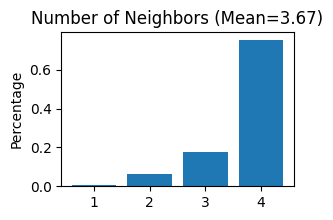

In [12]:
GEMVAE.Cal_Spatial_Net(gdata, rad_cutoff=1)
GEMVAE.Stats_Spatial_Net(gdata)

------Calculating spatial graph...
The graph contains 6212 edges, 1691 cells.
3.6736 neighbors per cell on average.


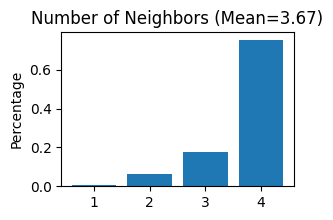

In [13]:
GEMVAE.Cal_Spatial_Net(pdata, rad_cutoff=1)
GEMVAE.Stats_Spatial_Net(pdata)

In [14]:
#parameters 
epochs = 400
hidden_dims_gene = [512,30]
hidden_dims_pro = [128, 30]
alpha = 0.35
pre_resolution_gene = 0.4
pre_resolution_pro = 0.2
save_loss = True

# Loss weights
kl_loss = 0.00
contrastive_loss = 10
weight_decay_loss = 1         #Loss for Ateentions Layers
recon_loss_type = 'ZINB'      # ZINB or MSE
recon_loss = 1
task = 'SPATIAL_SC'

In [15]:
trained_gdata = GEMVAE.train_GEMVAE(gdata,pdata,n_epochs=epochs,hidden_dims1=hidden_dims_gene,hidden_dims2=hidden_dims_pro,
                                    alpha=alpha,pre_resolution1=pre_resolution_gene,pre_resolution2=pre_resolution_pro, save_loss=save_loss,
                                    kl_loss = kl_loss,
                                    contrastive_loss = contrastive_loss,
                                    weight_decay_loss = weight_decay_loss,       
                                    recon_loss_type = recon_loss_type,   
                                    recon_loss = recon_loss,
                                    task = task)

Size of Input for gene data :  (1691, 3000)
Size of Input for protein data :  (1691, 283)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loss weights are =  10 1 1 0.0
START TRAIN
------Pre-clustering Genes using louvain with resolution=0.40
------Pre-clustering Protein using louvain with resolution=0.20
------Pruning the graph...
6212 edges before pruning.
3476 edges after pruning.
------Pruning the graph...
6212 edges before pruning.
4996 edges after pruning.
Epoch: 0, Contrastive Loss: 8.7442, Loss: 1929.7362
Epoch: 1, Contrastive Loss: 8.4817, Loss: 1921.9249
Epoch: 2, Contrastive Loss: 8.3292, Loss: 1923.3740
Epoch: 3, Contrastive Loss: 8.2486, Loss: 1924.4515
Epoch: 4, Contrastive Loss: 8.2077, Loss: 1919.3926
Epoch: 5, Contrastive Loss: 8.1870, Loss: 1921.3610
Epoch: 6, Contrastive Loss: 8.1767, Loss: 1917.6643
Epoch: 7, Contrastive Loss: 8.

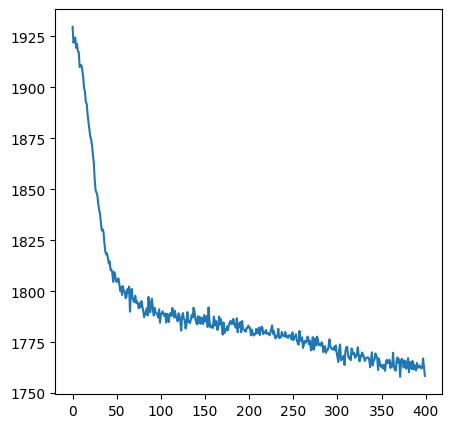

In [16]:
plt.plot(trained_gdata.uns['arch_loss'])
plt.show()

In [17]:
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.3.0"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.3.0\bin\x64" + ";" + os.environ["PATH"]

In [18]:
#DEFINE THE NUMBER OF CLUSTERS HERE
n_clusters = 6

In [19]:
for tool in ['mclust','leiden','louvain']:
   # we use mcluster as clustering tool by default.
   print("Using tool : ",tool)

   # performing PCA
   gdata.obsm['emb_combined_pca'] = sc.tl.pca(gdata.obsm['MY_ARCH'])

   # clustering
   if tool == 'mclust':
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='1', n_clusters=n_clusters, method=tool)
   elif tool in ['leiden']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='2', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.04)
   elif tool in ['louvain']:
      GEMVAE.clustering(gdata, key='emb_combined_pca', add_key='3', n_clusters=n_clusters, method=tool, start=0.01, end=1.3, increment=0.04)

Using tool :  mclust


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Using tool :  leiden
Searching resolution...
resolution=1.29, cluster number=10
resolution=1.25, cluster number=10
resolution=1.21, cluster number=9
resolution=1.17, cluster number=8
resolution=1.1300000000000001, cluster number=9
resolution=1.09, cluster number=8
resolution=1.05, cluster number=9
resolution=1.01, cluster number=8
resolution=0.97, cluster number=6
Using tool :  louvain
Searching resolution...
resolution=1.29, cluster number=7
resolution=1.25, cluster number=7
resolution=1.21, cluster number=7
resolution=1.17, cluster number=7
resolution=1.1300000000000001, cluster number=7
resolution=1.09, cluster number=6


Visualizing the clusters

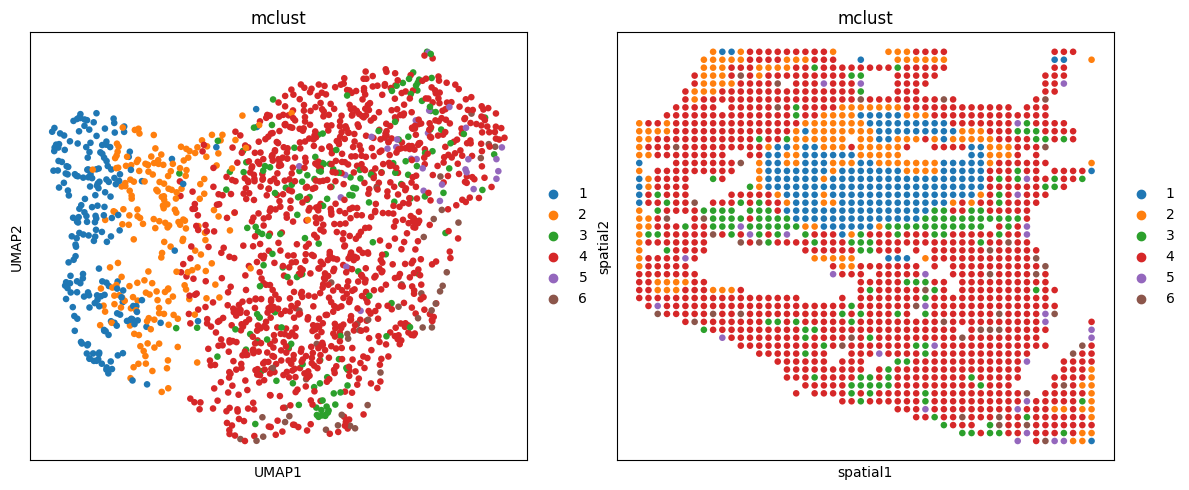

In [20]:
# visualization Mclust
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='1', ax=ax_list[0], title='mclust', s=90, show=False)
sc.pl.embedding(gdata, basis='spatial', color='1', ax=ax_list[1], title='mclust', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

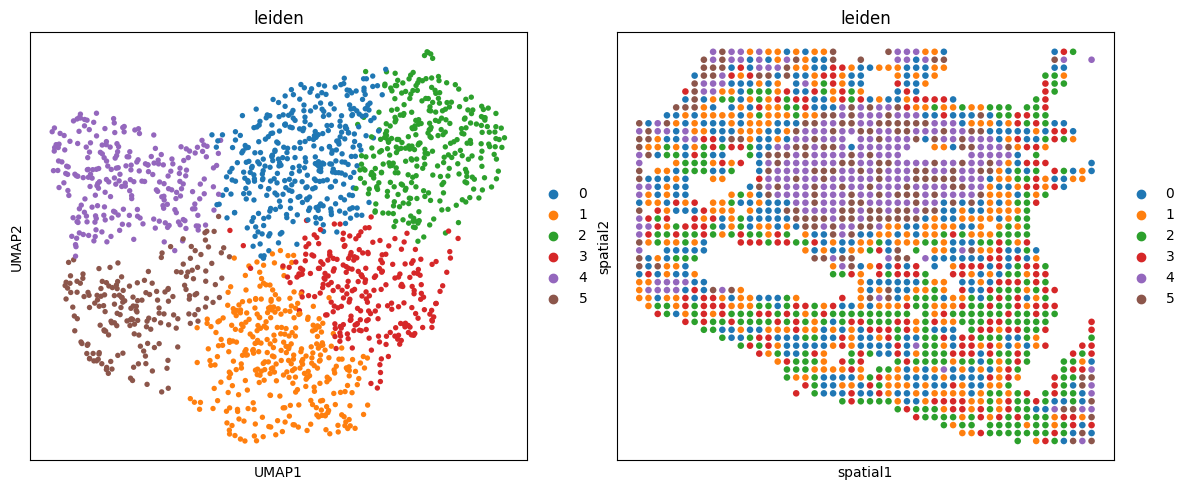

In [21]:
# visualization leiden
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='2', ax=ax_list[0], title='leiden', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='2', ax=ax_list[1], title='leiden', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

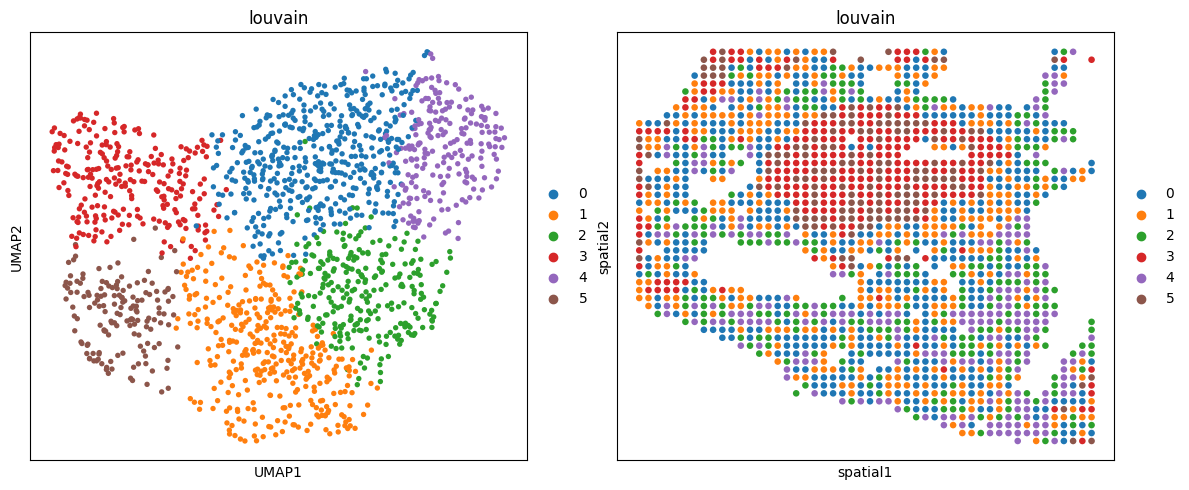

In [22]:
# visualization louven
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))
sc.pp.neighbors(gdata, use_rep='emb_combined_pca', n_neighbors=10)
sc.tl.umap(gdata)

sc.pl.umap(gdata, color='3', ax=ax_list[0], title='louvain', s=60, show=False)
sc.pl.embedding(gdata, basis='spatial', color='3', ax=ax_list[1], title='louvain', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()